In [84]:
import pandas as pd
import numpy as np
from config import *
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

def rename_columns(df):
    """Renames columns by joining multi-level column names with different delimiters."""
    # Iterate over all column names
    df.columns = [f"{col[0]}" if col[1] == '' else f"{col[0]}_{col[1]}" for col in df.columns.values]
    return df

In [48]:
df = pd.read_parquet(DATA_DIR / "anti_saccade_processed.pq")

In [49]:
n_correct_trials_df = (df
 .query("stimulus_active == True")
 .sort_values(by=["participant_id", "trial_id", "stand_time"])
 .assign(stimulus_time = lambda x: np.select([x.event == "FIXPOINT", x.event != "FIXPOINT"], [x.stand_time, None]))
 .ffill()
 .assign(saccade_direction = lambda x: np.where(x["sacc_end_x"] > x["sacc_start_x"], "right", "left"))
 .assign(is_trial_correct = lambda x: np.where(x["saccade_direction"] != x["stimulus_side"], True, False))
 .query("event == 'ESACC'")
 .groupby(["experiment","participant_id", "trial_id"])
 .first()
 .reset_index()
 .groupby(["experiment","participant_id"])
 .agg(n_correct_trials = ('is_trial_correct', 'sum'),
      n_trials = ('is_trial_correct', 'count'))
 .reset_index()
 .assign(prop_correct_trials = lambda x: x["n_correct_trials"] / x["n_trials"])
 [["experiment", "participant_id", "prop_correct_trials"]]
)

/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/1626662502.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()


In [50]:

reaction_time_df = (df
 .query("stimulus_active == True")
 .sort_values(by=["participant_id", "trial_id", "stand_time"])
 .assign(stimulus_time = lambda x: np.select([x.event == "FIXPOINT", x.event != "FIXPOINT"], [x.stand_time, None]))
 .ffill()
 .assign(saccade_direction = lambda x: np.where(x["sacc_end_x"] > x["sacc_start_x"], "right", "left"))
 .assign(is_trial_correct = lambda x: np.where(x["saccade_direction"] != x["stimulus_side"], True, False))
 .query("event == 'ESACC'")
 .groupby(["experiment","participant_id", "trial_id", "is_trial_correct"])
 .first()
 .reset_index()
 .assign(reaction_time = lambda x: x["stand_start_time"] - x["stimulus_time"])
 .groupby(["experiment","participant_id","is_trial_correct"])
 .agg(mean_reaction_time = ('reaction_time', 'mean'))
 .reset_index()
 .pivot(index=["experiment", "participant_id"], columns="is_trial_correct",values="mean_reaction_time")
 .reset_index()
 .rename({True: 'correct_reaction_time',
          False: 'incorrect_reaction_time'}, axis=1)
)


/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/3162244051.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()


In [85]:
features = (df.groupby(["experiment", "participant_id"])
 .agg({'peak_velocity': [np.mean, np.min, np.max, np.median, np.std],
       'amplitude': [np.mean, np.min, np.max, np.median, np.std],
       'duration': [np.mean, np.min, np.max, np.median, np.std],
       'avg_pupil_size': [np.mean, np.min, np.max, np.median, np.std]
       })
 .reset_index()
 .pipe(rename_columns)
)

features



/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/1974842887.py:2: FutureWarning: The provided callable <function mean at 0x10772bba0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({'peak_velocity': [np.mean, np.min, np.max, np.median, np.std],
/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/1974842887.py:2: FutureWarning: The provided callable <function min at 0x10772b2e0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg({'peak_velocity': [np.mean, np.min, np.max, np.median, np.std],
/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/1974842887.py:2: FutureWarning: The provided callable <function max at 0x10772b1a0> is currently using SeriesGroupBy.max. In a future version of pandas,

,experiment,participant_id,peak_velocity_mean,peak_velocity_min,peak_velocity_max,peak_velocity_median,peak_velocity_std,amplitude_mean,amplitude_min,amplitude_max,...,duration_mean,duration_min,duration_max,duration_median,duration_std,avg_pupil_size_mean,avg_pupil_size_min,avg_pupil_size_max,avg_pupil_size_median,avg_pupil_size_std
0,ANTI_SACCADE,103,365.240964,46.0,1015.0,212.0,349.958102,3.492222,0.18,16.19,...,454.274854,4.0,2816.0,198.0,673.387530,2369.681818,1715.0,2780.0,2381.0,240.786907
1,ANTI_SACCADE,105,276.612245,0.0,2147.0,115.0,392.326699,3.203007,0.02,24.61,...,377.983051,4.0,12949.0,117.0,1039.846504,2429.351351,1748.0,2985.0,2425.5,217.918754
2,ANTI_SACCADE,106,210.209091,44.0,400.0,215.0,98.088061,4.626727,0.25,16.88,...,395.087302,6.0,2830.0,105.5,663.817326,1584.873239,1278.0,2033.0,1569.0,158.880831
3,ANTI_SACCADE,109,334.558140,38.0,934.0,308.5,242.046112,6.252500,0.23,19.33,...,364.325843,4.0,2420.0,215.5,478.646179,2807.869565,2045.0,3199.0,2801.5,185.683899
4,ANTI_SACCADE,111,134.448630,39.0,441.0,94.0,95.472459,2.120034,0.00,18.52,...,161.648208,4.0,1291.0,64.5,211.451891,1119.034161,906.0,1370.0,1115.5,74.008895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,ANTI_SACCADE,404,198.435065,0.0,826.0,179.0,163.788040,4.016299,0.02,16.68,...,297.862275,4.0,1839.0,107.5,392.775171,1160.755556,844.0,1537.0,1160.5,164.754723
181,ANTI_SACCADE,87,373.803681,37.0,1127.0,290.0,333.185539,3.911902,0.23,33.73,...,277.062874,5.0,2547.0,142.0,425.604420,3004.847953,1936.0,3403.0,3049.0,252.021685
182,ANTI_SACCADE,89,279.475177,0.0,1652.0,144.0,280.500180,2.863162,0.00,10.50,...,358.835088,4.0,2997.0,153.0,546.087174,1160.805556,807.0,1534.0,1164.0,123.039267
183,ANTI_SACCADE,93,439.219512,44.0,1261.0,232.0,398.791813,3.842857,0.09,19.46,...,739.062992,6.0,49571.0,159.0,4402.165176,3227.977099,2089.0,3990.0,3176.0,443.705541


In [86]:
features = pd.merge(features, reaction_time_df, left_on=["experiment","participant_id"], right_on=["experiment", "participant_id"], how='left')
features = pd.merge(features, n_correct_trials_df, left_on=["experiment","participant_id"], right_on=["experiment", "participant_id"], how='left')

# Load outcome

In [7]:
demographics = pd.read_excel(DATA_DIR / "demographic_info.xlsx")[["ID", "Group"]]

demographics["y"] = (demographics["Group"] == "PATIENT").astype(int)
demographics["participant_id"] = demographics["ID"].astype(str)
demographics = demographics[["participant_id", "y"]]



# Model training

In [8]:
data = pd.merge(features, demographics, how='left', on='participant_id')
y_data = data["y"]
X_data = data[["correct_reaction_time", "incorrect_reaction_time", "prop_correct_trials"]]
X_data
#X_data = data.drop(["experiment", "participant_id", "y"], axis=1)

,correct_reaction_time,incorrect_reaction_time,prop_correct_trials
0,1001.285317,1538.785317,0.833333
1,794.321783,273.821783,0.666667
2,284.381760,254.851530,0.875000
3,822.070129,920.403463,0.333333
4,307.381760,210.245131,0.375000
...,...,...,...
180,245.006760,1036.707415,1.000000
181,872.357823,504.524489,0.500000
182,-53.211398,619.455269,0.333333
183,2011.743165,-6215.256835,0.333333


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(n_estimators=10, max_depth=6, learning_rate=1, objective='binary:logistic'))
])

print(pipe.fit(X_train, y_train).score(X_test, y_test))

results=pd.DataFrame()
results['columns']=X_train.columns
results['importances'] = pipe["clf"].feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results

0.5135135135135135


,columns,importances
0,correct_reaction_time,0.394957
2,prop_correct_trials,0.338878
1,incorrect_reaction_time,0.266165


# Decceleration

In [16]:
anti_saccade_samples = (pd.read_parquet(RAW_DIR / 'ANTI_SACCADE_SAMPLES.pq')
 .sort_values(["experiment", "participant_id", "trial_id","time"])
)

In [89]:
acceleration = (anti_saccade_samples.join((anti_saccade_samples
 .groupby(["experiment", "participant_id", "trial_id"])[['x_velocity_left', 'y_velocity_left', 'x_velocity_right', 'y_velocity_right']].shift(1)
 .rename(columns={'x_velocity_left': 'x_velocity_left_lagged'
          , 'y_velocity_left': 'y_velocity_left_lagged'
          , 'x_velocity_right': 'x_velocity_right_lagged'
          , 'y_velocity_right': 'y_velocity_right_lagged'}))
).assign(x_acceleration_left = lambda x: (x["x_velocity_left"] - x["x_velocity_left_lagged"]) / (1/2000),
         y_acceleration_left = lambda x: (x["y_velocity_left"] - x["y_velocity_left_lagged"]) / (1/2000),
         x_acceleration_right = lambda x: (x["x_velocity_right"] - x["x_velocity_right_lagged"]) / (1/2000),
         y_acceleration_right = lambda x: (x["y_velocity_right"] - x["y_velocity_right_lagged"]) / (1/2000))
 .assign(total_acceleration_magnitude_left = lambda x: np.sqrt( np.power(x["x_acceleration_left"], 2) + np.power(x["y_acceleration_left"], 2)),
         total_acceleration_magnitude_right = lambda x: np.sqrt( np.power(x["x_acceleration_right"], 2) + np.power(x["y_acceleration_right"], 2)))
 .groupby(["experiment", "participant_id", "trial_id"])
 .agg({'total_acceleration_magnitude_left': [np.mean, np.min, np.max, np.median, np.std],
       'total_acceleration_magnitude_right': [np.mean, np.min, np.max, np.median, np.std]
       })
 .reset_index()
 .pipe(rename_columns)
)



/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/746489960.py:14: FutureWarning: The provided callable <function mean at 0x10772bba0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({'total_acceleration_magnitude_left': [np.mean, np.min, np.max, np.median, np.std],
/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/746489960.py:14: FutureWarning: The provided callable <function min at 0x10772b2e0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  .agg({'total_acceleration_magnitude_left': [np.mean, np.min, np.max, np.median, np.std],
/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_26493/746489960.py:14: FutureWarning: The provided callable <function max at 0x10772b1a0> is currently using SeriesGro

(-5.0, 5.0)

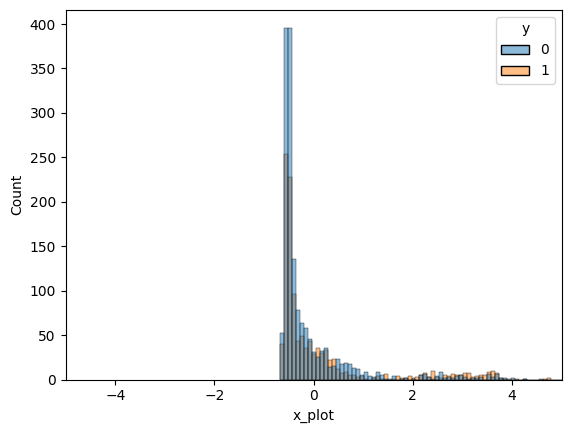

In [104]:
plotting_variable = "total_acceleration_magnitude_right_max"

acceleration_with_info = pd.merge(acceleration, demographics, how='left', on='participant_id').assign(x_plot = lambda x: (x[plotting_variable] -  x[plotting_variable].mean()) /  x[plotting_variable].std())

sns.histplot(acceleration_with_info, x='x_plot', hue='y')
plt.xlim(-5,5)



